In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import missingno as msno

import warnings 
warnings.filterwarnings('ignore')

from pathlib import Path
csv_path = Path("data") / "train_merged.csv"
# csv_path = os.path.join("data", "train_merged.csv")   os ile alternatif..

In [2]:
df = pd.read_csv(csv_path, low_memory=False)  # gerekirse encoding='utf-8' ekleyin
print(df.shape)
display(df.head())  # Jupyter'de güzel gösterim

(590540, 422)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [76]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def plot_categorical_analysis(df, column, target='isFraud'):
    """
    Sol tarafta kategorinin dağılımını (Pie), sağ tarafta ise
    Fraud oranlarını (100% Stacked Bar) gösteren birleşik grafik çizer.
    """
    # Genel stil ve renk ayarları
    sns.set_style('whitegrid')
    pastel_colors = sns.color_palette('pastel')
    
    # Şekil alanını oluştur (1 satır, 2 sütun)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=120)

    # --- 1. SOL GRAFİK: Pasta Grafiği (Hacim Dağılımı) ---
    counts = df[column].value_counts()
    
    axes[0].pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=pastel_colors, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}, # Yumuşak kenarlar
        textprops={'fontsize': 11}
    )
    axes[0].set_title(f'{column} Genel Dağılımı', fontsize=15, fontweight='bold')

    # sağdaki grafik
    crosstab = pd.crosstab(df[column], df[target], normalize='index') * 100
    
    # Pandas plot fonksiyonunu matplotlib eksenine (ax=axes[1]) yönlendiriyoruz
    # Renkler: 0 (Normal) için Pastel Mavi, 1 (Fraud) için Pastel Turuncu/Kırmızı
    bar_colors = [pastel_colors[0], pastel_colors[3]] 
    
    crosstab.plot(
        kind='bar', 
        stacked=True, 
        ax=axes[1], 
        color=bar_colors, 
        width=0.7,
        edgecolor='white'
    )
    
    axes[1].set_title(f'{column} İçindeki Fraud vs Normal Dağılımı', fontsize=15, fontweight='bold')
    axes[1].set_ylabel('Oran (%)', fontsize=12)
    axes[1].set_xlabel(column, fontsize=12)
    axes[1].legend(title='Durum', labels=['Normal', 'Fraud'], loc='upper right', frameon=True)
    
    # X ekseni yazılarını düzelt
    axes[1].tick_params(axis='x', rotation=0)

    # Barların üzerine yüzdeleri yazdırma (Annotation)
    for c in axes[1].containers:
        # Sadece %2'den büyük dilimlere yazı yazalım ki grafik boğulmasın
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 2 else '' for v in c]
        axes[1].bar_label(c, labels=labels, label_type='center', fontsize=10, color='black', weight='bold')

    plt.tight_layout()
    plt.show()


def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [47]:
train_df = df.copy()

Categorical Features - Transaction

ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

Categorical Features - Identity
* DeviceType
* DeviceInfo
* id_12 - id_38

KAtegorik ve sayısa özelliklerin ayrı incelenmesi adına bu özellikleri ayırmak gerekiyor.

In [35]:
categorical_features = [
    'ProductCD', 'P_emaildomain', 'R_emaildomain','DeviceType', 'DeviceInfo',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
    'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]
numerical_features = [col for col in train_df.columns if col not in categorical_features]

In [36]:
resumetable(train_df)[:25]

Dataset Shape: (590540, 422)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int64,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int64,0,2,0,0,0,0.22
2,TransactionDT,int64,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float64,0,8195,68.5,29.0,59.0,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int64,0,13553,13926,2755,4663,9.97
6,card2,float64,8933,500,NaN,404.0,490.0,6.32
7,card3,float64,1565,114,150.0,150.0,150.0,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float64,4259,119,142.0,102.0,166.0,2.66


Entropy : 
    --> Measures the uncertainty or randomness of the data distribution in each column, using Shannon entropy. It quantifies how evenly the values are spread.

> **High entropy** (closer to log2 of unique values): Values are diverse and evenly distributed (e.g., many unique categories with similar frequencies).

> **Low entropy** (closer to 0): Values are concentrated (e.g., mostly one value or few dominant ones).

In [48]:
top_missing_cols(train_df, thresh=90)

There are 402 columns in this dataset with missing values.
There are 0 columns with missing percent values than 90%


,col,missing_percent
0,D13,89.509263
1,D14,89.469469
2,D12,89.041047
3,id_04,88.768923
4,id_03,88.768923
5,D6,87.606767
6,id_33,87.589494
7,D9,87.312290
8,D8,87.312290
9,id_09,87.312290


Ben belli ki veriyi indirirken sorun yaşadım , benzer çalışmalarda farkı gözüküyor. Ayrıca bazı sütunlar da bende eksik zaten sebebini anlamadım şimdilik.

### Target Analysis

Class distribution for 'isFraud':
isFraud
0    569877
1     20663
Name: count, dtype: int64

Normalized:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64


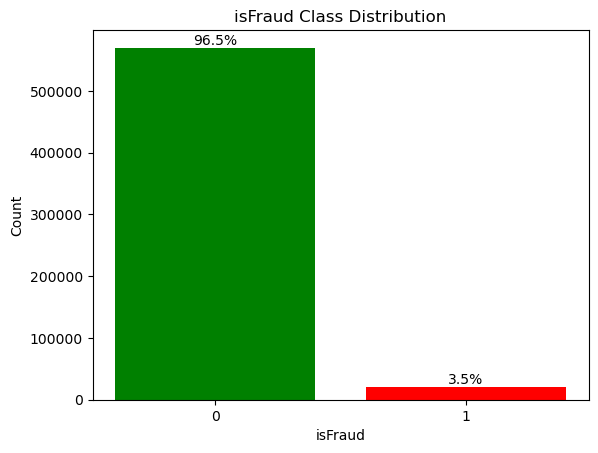

In [22]:
# Replace the visualization part in the existing cell
print("Class distribution for 'isFraud':")
print(train_df['isFraud'].value_counts())
print("\nNormalized:")
print(train_df['isFraud'].value_counts(normalize=True))


counts = train_df['isFraud'].value_counts()
percentages = train_df['isFraud'].value_counts(normalize=True) * 100

colors = ['green', 'red'] 
bars = plt.bar(counts.index, counts.values, color=colors[:len(counts)])

plt.title('isFraud Class Distribution')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.xticks([0, 1])

# Add percentages on bars
for bar, perc in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{perc:.1f}%', ha='center', va='bottom')

plt.show()

Verinin Dengesiz olduğuna dair şeyler yazılacak.

# Categorical Features Analysis

Tüm kategorik özelliler analize uygun değil bazılarının kardinalitesi aşırı fazla olduğu için anlamsız sonuçlar veriyorlar haliyle bunları ayırdıktan sonra incelemeye uygun olan kategorik özellikleri hedefe göre analiz ediyoruz.

Kategorik özelliklerin kısa açıklamaları : 

* ProductCD [Categorical]: product code(the product for each transaction)
* card1–6 [Categorical]: payment card related information like card type, country etc
* addr1, addr2 [Categorical]: address information
* P_emaildomain [Categorical]: email domain of purchaser.
* R_emaildomain [Categorical]: email domain of the recipient.
* M1-M9 [Categorical]: match, such as names on card and address, etc.
* DeviceType [Categorical]: Type of device used for the transaction
* DeviceInfo [Categorical]: More information about device used

İd için ayrı bakılabilir belki : 

* id 1–38 [Categorical+numeric]: network connection information,browser information etc (id 12–38 are categorical information)

In [43]:
missing_cols = [col for col in categorical_features if col not in train_df.columns]
print("Missing categorical features:", missing_cols)
print("Total categorical features:", len(categorical_features))
print("Present categorical features:", len(categorical_features) - len(missing_cols))

present_cols = [col for col in categorical_features if col in train_df.columns]
# resumetable(train_df[present_cols])

# 
low_cardinality = [col for col in present_cols if train_df[col].nunique() <= 10]
high_cardinality = [col for col in present_cols if train_df[col].nunique() > 10]

# Update categorical_features to only low cardinality
categorical_features = low_cardinality

# Create a new list for high cardinality
cardinality_features = high_cardinality

print("Low cardinality categorical features:", low_cardinality)
print("High cardinality categorical features:", high_cardinality)

Missing categorical features: ['id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Total categorical features: 49
Present categorical features: 41
Low cardinality categorical features: ['ProductCD', 'DeviceType', 'card4', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
High cardinality categorical features: ['P_emaildomain', 'R_emaildomain', 'DeviceInfo', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33']


Hala aşırı fazla kategorik özellik olduğuna göre diğer çalışmalardan da faydalanarak en çok önemli görülenleri incelemeliyiz.


Bu özellikleri konu başlıklarına göre ayırabiliriz : 
* Kart Özellikleri : 
    * These columns represent payment information related to cards
    * There is a wide range of values in card1. If we see the distribution there are overlapping's. card1 alone cannot between fraudulent and nonfraudulent transactions. No missing values are there in card1.
    * A small percent of data is missing in card2. Similar to card1 a lot of unique values are present in card2 also. card3 has low correlation with other card columns.
    * card 4 indicates which type of card do client uses visa, Mastercard, American Express, or discover. Similarly, card6 the type of card- debit or credit.
    * 
    * 
        * As the Card 1 and 2 are numericals, I will plot the distribution of them
        * in Card 3, as we have many values with low frequencies, I decided to set value to "Others"
        * Also, in Card 3 I set the % of Fraud ratio in yaxis2 
 * Adres Özellikleri : 
    * 




In [56]:
card_features = [col for col in train_df.columns if col.startswith('card')]
resumetable(train_df[card_features])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int64,0,13553,13926,2755,4663,9.97
1,card2,float64,8933,500,NaN,404.0,490.0,6.32
2,card3,float64,1565,114,150.0,150.0,150.0,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float64,4259,119,142.0,102.0,166.0,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


In [65]:
# card3 için 200'den az geçenleri 'Others' yap
valid_card3 = train_df['card3'].value_counts()
train_df.loc[train_df['card3'].isin(valid_card3[valid_card3 < 200].index), 'card3'] = "Others"

# card5 için 300'den az geçenleri 'Others' yap
valid_card5 = train_df['card5'].value_counts()
train_df.loc[train_df['card5'].isin(valid_card5[valid_card5 < 300].index), 'card5'] = "Others"

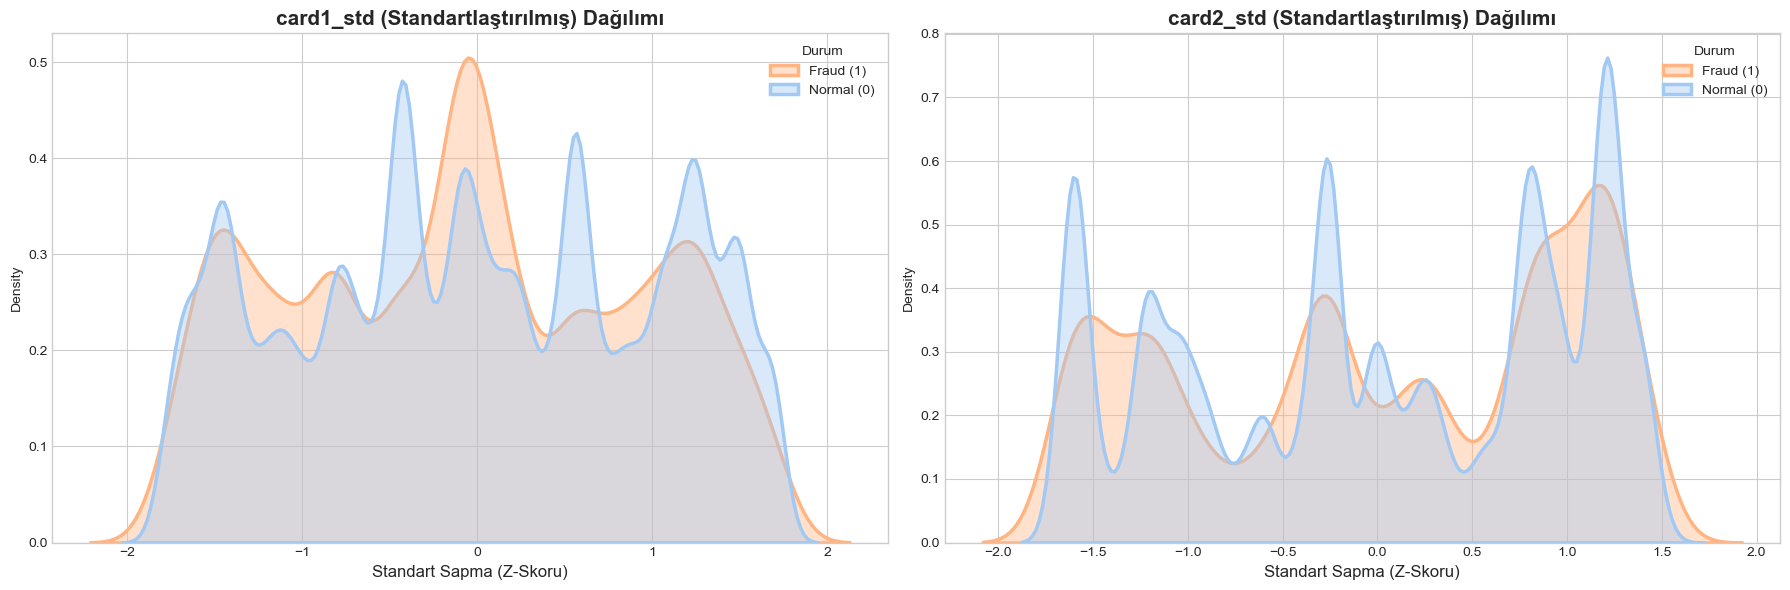

In [66]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

# Standardization.
for col in ['card1', 'card2']:
    col_mean = train_df[col].mean()
    col_std = train_df[col].std()
    train_df[f'{col}_std'] = (train_df[col] - col_mean) / col_std

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

features_std = ['card1_std', 'card2_std']

for i, col in enumerate(features_std):
    sns.kdeplot(
        data=train_df, 
        x=col, 
        hue='isFraud', 
        fill=True, 
        alpha=0.4, 
        common_norm=False, 
        ax=axes[i],
        linewidth=2.5
    )
    
    axes[i].set_title(f'{col} (Standartlaştırılmış) Dağılımı', fontsize=15, fontweight='bold')
    axes[i].set_xlabel('Standart Sapma (Z-Skoru)', fontsize=12)
    
    # Efsane (Legend) başlığını düzeltelim
    axes[i].legend(title='Durum', labels=['Fraud (1)', 'Normal (0)'])

plt.tight_layout()
plt.show()

# İşi bitince geçici sütunları silebilirsin istersen:
# train_df.drop(columns=['card1_std', 'card2_std'], inplace=True)

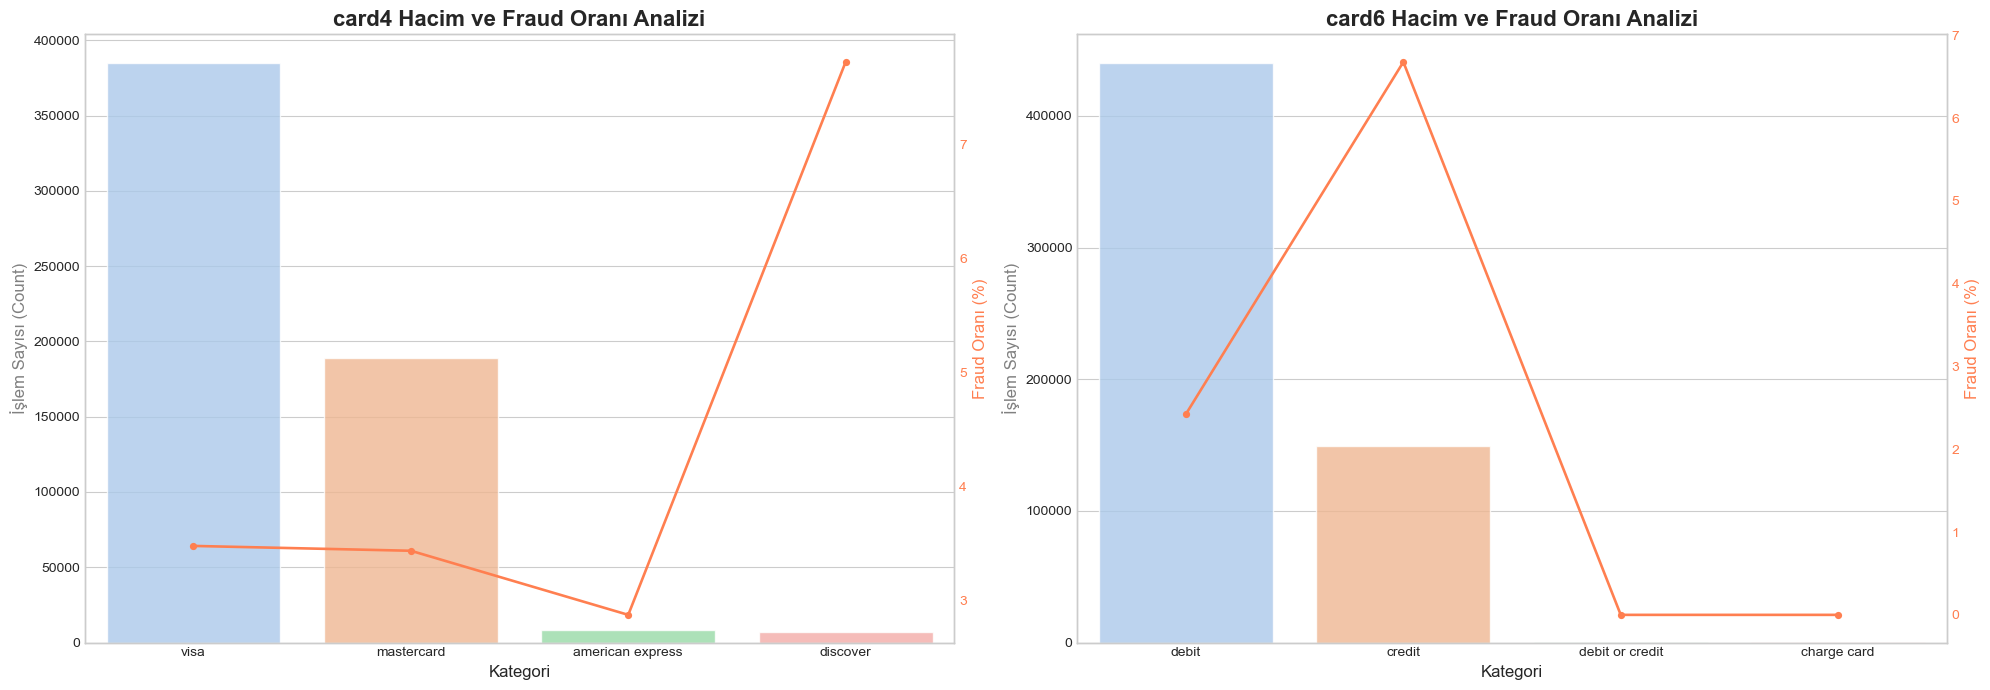

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for i, col in enumerate(['card4', 'card6']):
    tmp = pd.crosstab(train_df[col], train_df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={1: 'FraudRate', 0: 'NoFraudRate'}, inplace=True)
    
    # Toplam işlem sayılarını da alalım
    total_count = train_df[col].value_counts().reset_index()
    total_count.columns = [col, 'Count']
    
    # Verileri birleştir (Merge)
    plot_data = pd.merge(total_count, tmp, on=col)
    plot_data = plot_data.sort_values(by='Count', ascending=False) # sort
    
    # --- 2. Çift Eksenli Grafik Çizimi ---
    ax1 = axes[i]
    ax2 = ax1.twinx() 
    
    # Bar Plot --> işlem hacmi
    sns.barplot(
        x=col, 
        y='Count', 
        data=plot_data, 
        ax=ax1, 
        palette='pastel', 
        alpha=0.8,
        edgecolor='white'
    )
    
    # Line Plot --> fraud yüzdesi
    sns.pointplot(
        x=col, 
        y='FraudRate', 
        data=plot_data, 
        ax=ax2, 
        color ='#ff7f50', 
        markers='o',
        scale=0.7 
    )
    
    
    ax1.set_title(f'{col} Hacim ve Fraud Oranı Analizi', fontsize=16, fontweight='bold')
    
    
    ax1.set_xlabel('Kategori', fontsize=12)
    ax1.set_ylabel('İşlem Sayısı (Count)', fontsize=12, color='gray')
    ax2.set_ylabel('Fraud Oranı (%)', fontsize=12, color='#ff7f50')
    
    
    ax2.tick_params(axis='y', colors='#ff7f50')
    
    
    ax2.grid(False)

plt.tight_layout()
plt.show()

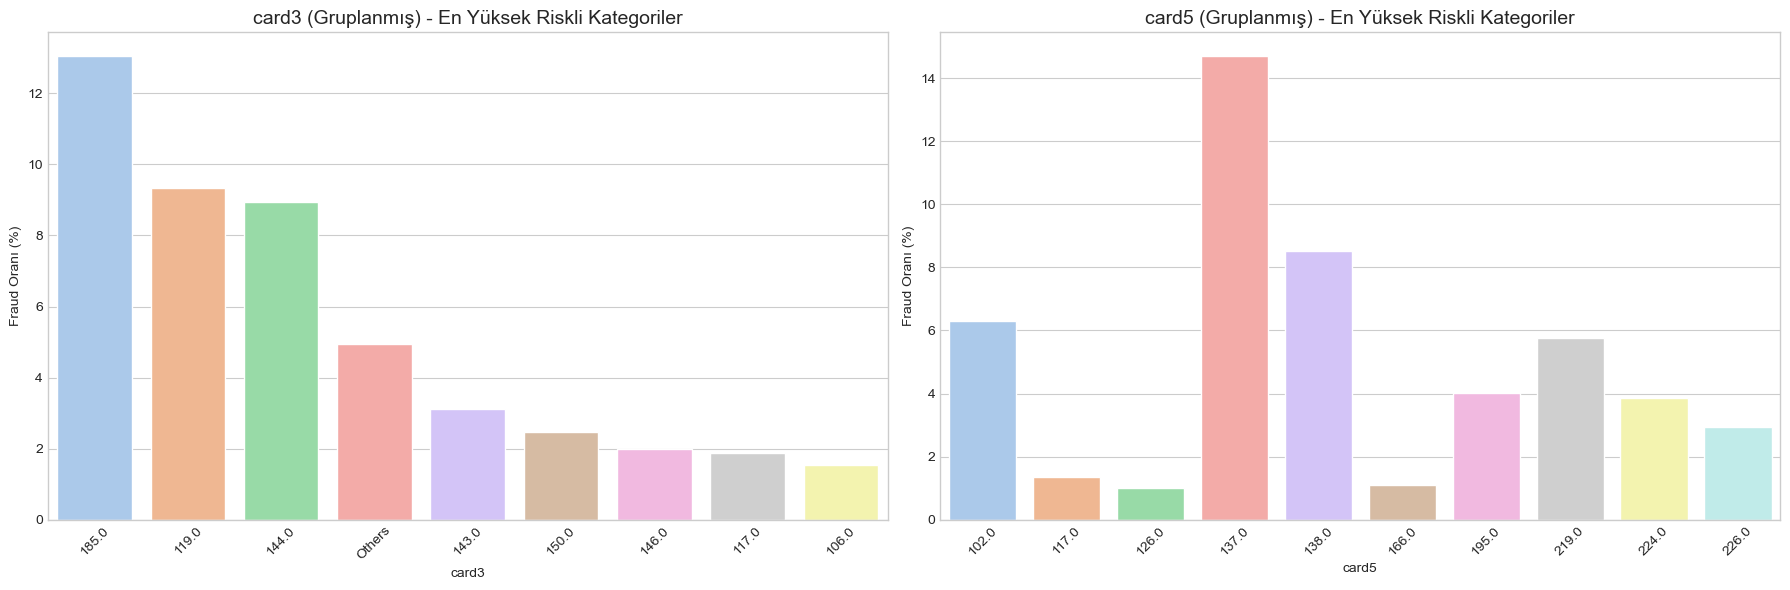

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for i, col in enumerate(['card3', 'card5']):
    top_categories = train_df[col].astype(str).value_counts().head(10).index
    
    plot_data = train_df[train_df[col].astype(str).isin(top_categories)]
    

    rate_df = plot_data.groupby(col)['isFraud'].mean().reset_index()
    rate_df.columns = [col, 'FraudRate']
    rate_df['FraudRate'] = rate_df['FraudRate'] * 100 
    rate_df = rate_df.sort_values(by='FraudRate', ascending=False)
    
    sns.barplot(
        x=col, 
        y='FraudRate', 
        data=rate_df, 
        palette='pastel', 
        ax=axes[i],
        edgecolor='white'
    )
    
    axes[i].set_title(f'{col} En Yüksek Riskli Kategoriler', fontsize=14)
    axes[i].set_ylabel('Fraud Oranı (%)')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In card5 the most frequent values are 226, 224, 166 that represents 73% of data. Also is posible to see high % of frauds in 137, 147, 141 that has few entries for values.

yukaıdaki görselde bu kategorilerin tüme oranı yok sadece risk durumları var.


##### ProductCD özelliği

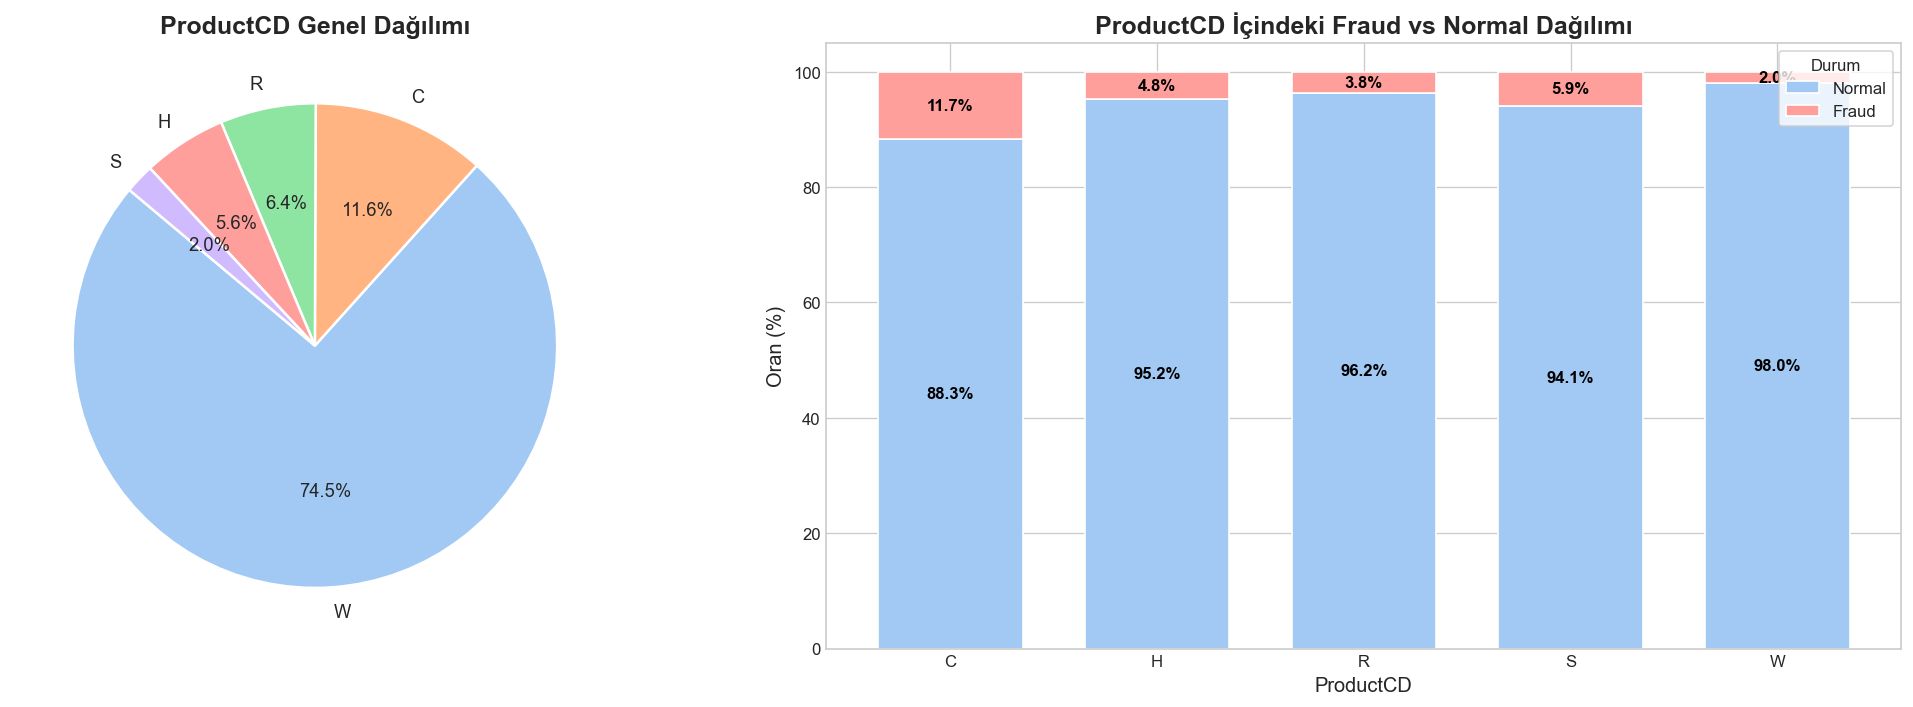

In [77]:
plot_categorical_analysis(train_df,'ProductCD')

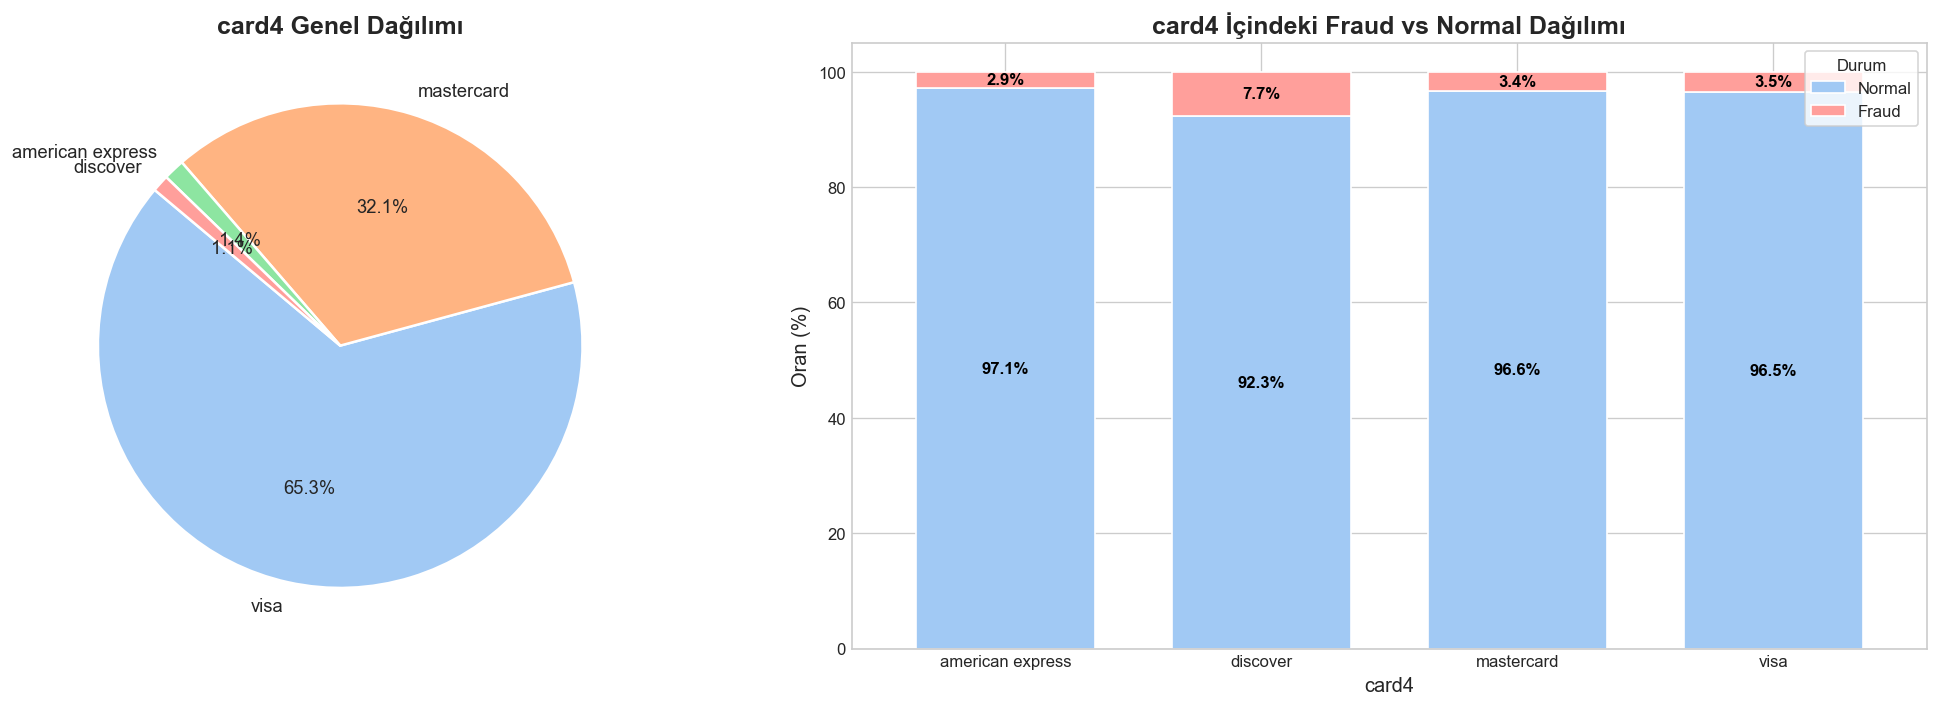

In [ ]:
plot_categorical_analysis(train_df,'card4')

In [ ]:
# cross_tab = train_df.groupby(['ProductCD', 'card4'])['isFraud'].mean().reset_index()
# cross_tab['FraudRate'] = cross_tab['isFraud'] * 100


# g = sns.catplot(
#     x='card4', 
#     y='FraudRate', 
#     col='ProductCD', # Her Ürün Kodu için ayrı bir grafik
#     data=cross_tab, 
#     kind='bar', 
#     palette='pastel',
#     height=4, 
#     aspect=0.8,
#     col_wrap=3 # Yan yana en fazla 3 grafik olsun, sığmazsa aşağı geçsin
# )


# g.fig.suptitle('ProductCD ve Card4 İlişkisi: Fraud Oranları', y=1.02, fontsize=16)
# g.set_titles("{col_name}") 
# g.set_axis_labels("", "Fraud Oranı (%)")

# # bar üzerindeki oranlar
# for ax in g.axes.flat:
#     for p in ax.patches:
#         if p.get_height() > 0: # değeri olanlar için.
#             ax.text(
#                 p.get_x() + p.get_width() / 2., 
#                 p.get_height() + 0.5, 
#                 f'{p.get_height():.1f}%', 
#                 ha='center', 
#                 va='bottom', 
#                 fontsize=9, 
#                 color='gray'
#             )
#     ax.tick_params(axis='x', rotation=45)

# plt.show()